# Network Playground using GoT Dataset (2): Understanding the clusters

Network or Graph is a special representation of entities which have relationships among themselves. It is made up of a collection of two generic objects — (1) node: which represents an entity, and (2) edge: which represents the connection between any two nodes. In a complex network, we also have attributes or features associated with each node and edge. 

## Winter is Coming. Let's load the dataset ASAP!

If you haven't heard of Game of Thrones, then you must be really good at hiding. Game of Thrones is the hugely popular television series by HBO based on the (also) hugely popular book series A Song of Ice and Fire by George R.R. Martin. In this notebook, we will analyze the co-occurrence network of the characters in the Game of Thrones books. Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books.

Note we dont care what happened exactly to a person. A dead person who is often mentioned is in some way also powerful

This notebook tries to answer the following question by applying graph theory:
- How many main forces are there and who are the members

## Install the Python Packages

In [1]:
!pip install pandas
!pip install python-dateutil
!pip install networkx
!pip install pyvis

## Load the Dataset

<a href="https://www.kaggle.com/code/mmmarchetti/game-of-thrones-network-analysis">GoT Dataset</a>
Please download the csv files from the link above and save them under the same directory as this notebook.

Lets directly jump to book 5 which is the last dataset, since we want to guess who is winning in the end. We will show the network extracted from book 5. 

In [2]:
import networkx as nx
import pandas as pd
from pyvis.network import Network
# Reading in datasets/book5.csv
book5 = pd.read_csv('book5.csv')


G5 = nx.from_pandas_edgelist(book5, source='Source', target="Target")
#print(net5.nodes)

## How many main forces are there over Westeros?

In [3]:
!pip install node2vec
!pip install tqdm
from node2vec import Node2Vec

In [4]:
from tqdm import tqdm as tqdm
node2vec = Node2Vec(G5, dimensions=64, walk_length=30, num_walks=200, workers=4) 

Computing transition probabilities:   0%|          | 0/317 [00:00<?, ?it/s]

In [5]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)


In [6]:
EMBEDDING_FILENAME = "embedding.txt"
# Look for most similar nodes
model.wv.most_similar('Daenerys-Targaryen')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

In [7]:
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
print(model.wv.most_similar('Daenerys-Targaryen'))
print(model.wv.most_similar('Theon-Greyjoy'))

[('Lysono-Maar', 0.858216404914856), ('Eroeh', 0.8578234314918518), ('Daeron-II-Targaryen', 0.8544033765792847), ('Quaithe', 0.8537705540657043), ('Ghael', 0.8477191925048828), ('Ezzara', 0.8446870446205139), ('Yurkhaz-zo-Yunzak', 0.843950629234314), ('Barsena', 0.8438562154769897), ('Aegon-I-Targaryen', 0.8433037996292114), ('Xaro-Xhoan-Daxos', 0.8013366460800171)]
[('Wex-Pyke', 0.8636282682418823), ('Harwood-Stout', 0.8574608564376831), ('Willow-Witch-eye', 0.8519238233566284), ('Ben-Bones', 0.8486949801445007), ('Ramsay-Snow', 0.8307322263717651), ('Damon-Dance-for-Me', 0.8303743600845337), ('Sour-Alyn', 0.8232454061508179), ('Jeyne-Poole', 0.8224214315414429), ('Yellow-Dick', 0.8181679844856262), ('Grunt', 0.811894953250885)]


In [8]:
print(model.wv.index_to_key[0])
print(model.wv.vectors[0])



Jon-Snow
[-0.10745176 -0.10762125 -0.46071255 -0.40798414 -0.17255518 -0.08628251
 -0.03427149 -0.3933262  -0.3154531  -0.12611404  0.1324946   0.18002868
 -0.02126015  0.33901855 -0.07800957  0.37281471 -0.5100801   0.03938003
  0.36715388 -0.15915413 -0.08042224  0.311753   -0.26582146  0.20422289
  0.3644865  -0.58046514 -0.21385229  0.6624418  -0.28228575 -0.15972085
  0.3498503   0.19522932  0.3075667  -0.13178107  0.224344   -0.18407051
  0.15998998  0.01123041  0.16579932  0.4206959   0.06083994  0.02487288
  0.33749428  0.18902573  0.0379461   0.17632    -0.32566297  0.35432115
  0.3654549   0.336261    0.01464563 -0.07861567 -0.01111674 -0.12318905
 -0.20233528 -0.2944318   0.3649441  -0.2416933  -0.2205302   0.38343292
 -0.5433768   0.0728847  -0.19416717  0.15945911]


In [9]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (model.wv.vectors) 

In [10]:
!pip install sklearn
!pip install scipy
!pip install --upgrade scikit-learn
!pip install matplotlib

Requirement already up-to-date: scikit-learn in /home/ming/.local/lib/python3.8/site-packages (1.1.3)


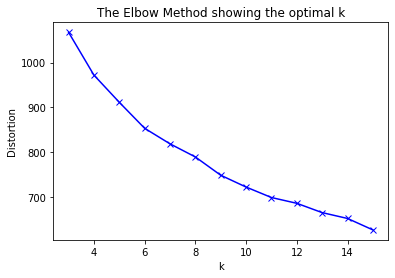

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
K = range(3,16)
for k in K:
    k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(node_embeddings)
    k_cluster.fit(node_embeddings)
    distortions.append(k_cluster.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4().

In [12]:
!pip install hdbscan
# get k-means clustering for 14 labels
kmeans_cluster = KMeans(n_clusters=14, 
                        init='k-means++', n_init=300, random_state=3425).fit(node_embeddings)
kmeans_labels = kmeans_cluster.labels_

# run the HDBSCAN cluster
import hdbscan
hdbs_model = hdbscan.HDBSCAN(min_cluster_size = 5)
hdbs_model.fit(node_embeddings)
hbds_scan_labels = hdbs_model.labels_

# create a dataframe of the nodes with their cluster labels
nodes_labels = pd.DataFrame(zip(node_ids, kmeans_labels, hbds_scan_labels), 
                            columns = ['node_ids','kmeans','hdbscan'])


/home/ming/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


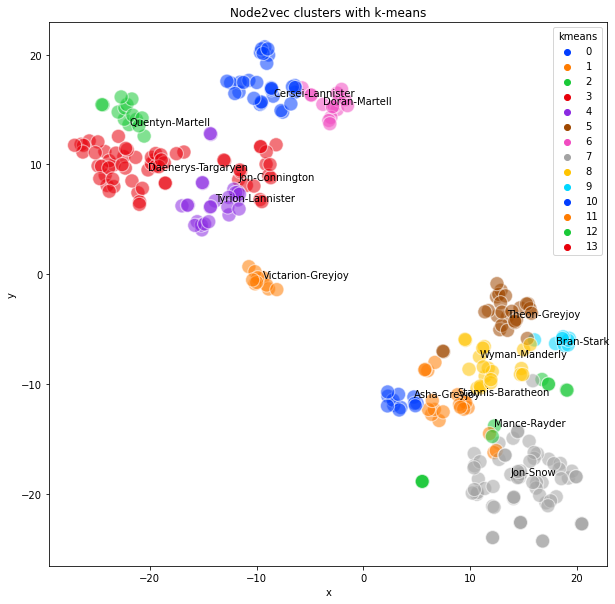

In [13]:
!pip install seaborn
# fit our embeddings with t-SNE
from sklearn.manifold import TSNE
trans = TSNE(n_components = 2, early_exaggeration = 10,
                  perplexity = 35, n_iter = 1000, n_iter_without_progress = 500,
                  learning_rate = 600.0, random_state = 42)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# create the dataframe that has information about the nodes and their x and y coordinates
data_tsne = pd.DataFrame(zip(node_ids, list(node_embeddings_2d[:,0]),list(node_embeddings_2d[:,1])),
                        columns = ['node_ids','x','y'])
data_tsne = pd.merge(data_tsne, nodes_labels, left_on='node_ids', right_on='node_ids',
                how = 'left')
# plot using seaborn.
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_tsne, x='x', y='y',hue='kmeans', palette="bright",
               alpha=0.55, s=200).set_title('Node2vec clusters with k-means')



l = [True]*14
for row in data_tsne.iterrows():
    kmean_id = row[1]['kmeans']
    if l[kmean_id]:
        plt.text(x=row[1]['x'], y=row[1]['y'], s=row[1]['node_ids'])
        l[kmean_id] = False

plt.savefig('GoT.svg')

In [31]:
net5 = Network(notebook=True)
net5.from_nx(G5)

import random
r = lambda: random.randint(0,255)

colors = [""]*14 
colors = [('#%02X%02X%02X' % (r(),r(),r())) for a in colors]


# {'color': '#97c2fc', 'size': 10, 'id': 'Aegon-I-Targaryen', 'label': 'Aegon-I-Targaryen', 'shape': 'dot'}
for node in net5.nodes:
    person = node['id']
    for row in data_tsne.iterrows():
        if row[1]['node_ids']== person:
            kmean_id = row[1]['kmeans']
            node['color'] = colors[kmean_id]
            #print(person+":"+str(kmean_id))
#print(data_tsne)
net5.show("test5.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
